In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:

# Just looking to see what the data looks like
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()


# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Last data point",(last_date))

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Date 1 year ago from last data point",(last_year))


# Design a query to retrieve the last 12 months of precipitation data and plot the results

precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

precipitation_df = pd.DataFrame(precipitation)
precipitation_df.head(5)

# Perform a query to retrieve the data and precipitation scores





Last data point ('2017-08-23',)
Date 1 year ago from last data point 2016-08-23


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [13]:
# Sort the dataframe by date

precipitation_df.sort_values(by='date').head(5)


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df.set_index('date').head(5)


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


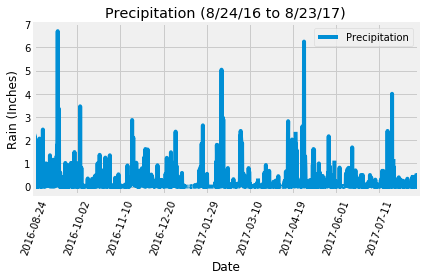

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain (Inches)")
plt.title("Precipitation (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Measurement).group_by(Measurement.station).count()
print("Number of stations:  {}".format(stations))

Number of stations:  9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


station_activity = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

most_active = station_activity[0][0]    
print("Most active station was",most_active,"with",station_activity[0][1],"weather observations.")
print()
print("All stations with their number of observations:")

for station, count in station_activity:
    
    print(station,"  ",count)

Most active station was USC00519281 with 2772 weather observations.

All stations with their number of observations:
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838    511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == "USC00519281")
avg_tmp_rec = "{0:.1f}".format(most_active_station[0][4])
print(f"Lowest temperature recorded:  {most_active_station[0][2]}\
    Highest temperture recorded :  {most_active_station[0][3]}    Average temperature recorded:  {avg_tmp_rec}")


Lowest temperature recorded:  54.0    Highest temperture recorded :  85.0    Average temperature recorded:  71.7


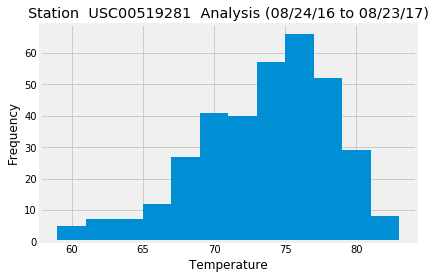

In [20]:
# Choose the station with the highest number of temperature observations.

observations = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

observations_df=pd.DataFrame(observations)
plt.hist(observations_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station  " +   most_active   + "  Analysis (08/24/16 to 08/23/17)")
plt.show()


![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_trip = dt.date(2017, 8, 1)
end_trip = dt.date(2017, 8, 15)
last_year = dt.timedelta(days=365)
avg_temp_last_yr = (calc_temps((start_trip-last_year), (end_trip-last_year)))
print(avg_temp_last_yr)


[(71.0, 78.17525773195877, 83.0)]


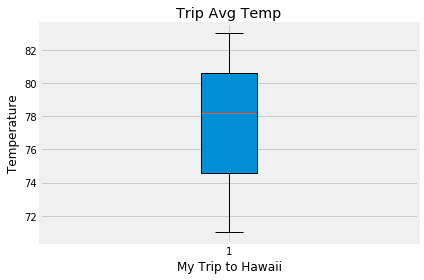

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


fig, ax = plt.subplots()
x = range(len(avg_temp_last_yr))
ax.boxplot(avg_temp_last_yr, patch_artist=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Temperature")
ax.set_xlabel("My Trip to Hawaii")
fig.tight_layout()
plt.show()


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stations = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_trip)\
.filter(Measurement.date <= end_trip)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

# Formatted layout 

print()
print (f"Rainfall Per Weather Station \n  Trip Dates: \
{start_trip} - {end_trip}\n  I used same Dates: {start_trip} - {end_trip}")
print()
for row in stations:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()
    



Rainfall Per Weather Station 
  Trip Dates: 2017-08-01 - 2017-08-15
  I used same Dates: 2017-08-01 - 2017-08-15

Station:  USC00516128
    Rainfall:  1.70  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  0.38  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00514830
    Rainfall:  0.33  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519523
    Rainfall:  0.14  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.06  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168



## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
